# Disaster Tweet Classification with tinyBERT

In recent years, Twitter, now called X, has emerged as a vital communication platform during emergencies, allowing users to share real-time updates about crises and disasters. The widespread availability of smartphones has empowered individuals to swiftly report on emergencies they witness, fostering a sense of immediacy and connection within affected communities. Consequently, this surge in user-generated content has caught the attention of various organizations, particularly disaster relief agencies and news outlets, which are now keen on programmatically monitoring Twitter for pertinent information. However, pinpointing relevant tweets amidst the vast ocean of posts has proven challenging. The inherent ambiguity found in the linguistic structures of tweets often complicates the process, making it difficult to ascertain whether a user's message genuinely conveys information about a disaster or simply discusses unrelated topics.

This dataset was obtained from Kaggle, which hosted a challenge named Real or Not. The primary objective of this challenge was to analyze Twitter data related to disaster tweets, which were originally curated by the company Figure-Eight. Participants in the challenge had the task of classifying these tweets into two distinct categories: those discussing actual disasters and those referencing disasters in a metaphorical or figurative context. This project aimed to enhance the understanding of public discourse surrounding disasters on social media.


## Selected Model for Classification

I will be using tinyBERT for this classification. BERT is designed to pre-train deep bidirectional representations from an unlabeled text by joint conditioning on the left and right context in all layers. As a result, the pre-trained BERT model can be fine-tuned with just one additional output layer to create state-of-the-art models for a wide range of tasks, such as question answering and language inference, without substantial task-specific architecture modifications.

### Disaster or general tweet?

### Download data

In [2]:
import pandas as pd


In [3]:
df = pd.read_csv("https://raw.githubusercontent.com/laxmimerit/All-CSV-ML-Data-Files-Download/master/twitter_disaster_tweets.csv", usecols=['text', 'target'])

df.head()

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
df.isnull().sum()

text      0
target    0
dtype: int64

In [5]:
df = df.sample(frac=1).reset_index(drop=True)
df

,text,target
0,Okay I need all of you to evacuate the house s...,0
1,FREYAS VIDEO BLEW UP EVERYWHERE,0
2,im getting a car wow it hasn't sunk in,0
3,@volcano_tornado live somewhere else for a whi...,1
4,First Tweet collided with a Selfie. Pretty 'Sw...,0
...,...,...
7608,Apparently they're going to have a WW2 siren t...,0
7609,@Safyuan just a minor citation for possesion o...,0
7610,i be on that hotboy shit,0
7611,MEG issues Hazardous Weather Outlook (HWO) ht...,1


In [6]:
df['target'].value_counts()

target
0    4342
1    3271
Name: count, dtype: int64

In [ ]:
!pip3 install matplotlib


In [8]:
import matplotlib

<Axes: >

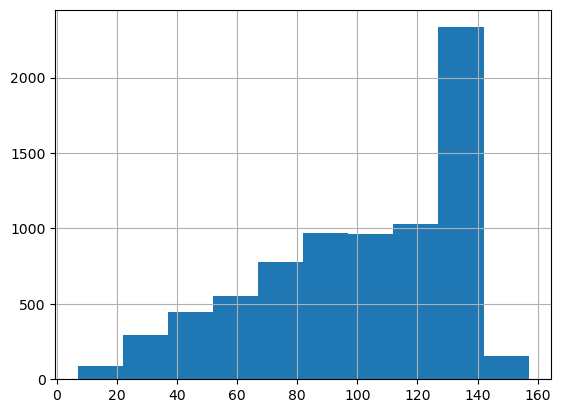

In [9]:
# case, un-cased
# context window -> 512 tokens
# 1 token -> 3char

df['text'].str.len().hist() #-> 160/3 => 53 => 60 tokens



### Load Data with Hugging Face Datasets Library


In [10]:
df = df.rename(columns={'target': 'label'})

In [ ]:
!pip install datasets

In [12]:
from datasets import Dataset

dataset = Dataset.from_pandas(df)

dataset = dataset.train_test_split(test_size=0.2)

dataset['train'][0]

{'text': 'Did anyone else see that fireball falling to earth? Look like a plane blew up.',
 'label': 1}

In [13]:
id2label = {0:'general', 1: 'disaster'}
label2id = {'general': 0, 'disaster': 1}


## Data Tokenization


In [ ]:
print("Using device:", device)
if torch.cuda.is_available():
    print("CUDA device name:", torch.cuda.get_device_name(0))


In [ ]:
!pip install transformers


In [ ]:
!pip3 install torch


In [15]:
from transformers import AutoTokenizer
import torch

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model_ckpt = 'huawei-noah/TinyBERT_General_4L_312D'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt, use_fast=True)


In [16]:
tokenizer(dataset['train'][0]['text'])

def tokenize(batch):
    temp = tokenizer(batch['text'], padding=True, truncation=True, max_length=100)
    return temp

dataset = dataset.map(tokenize, batched=True, batch_size=None)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Map:   0%|          | 0/6090 [00:00<?, ? examples/s]

Map:   0%|          | 0/1523 [00:00<?, ? examples/s]

In [17]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 6090
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1523
    })
})

## Building Model Evaluation Functions
https://huggingface.co/docs/transformers/v4.42.0/en/tasks/sequence_classification#evaluate

In [ ]:
!pip install evaluate

In [ ]:
!pip install numpy

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [18]:
import evaluate
import numpy as np

accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [ ]:
!pip3 install torch torchvision torchaudio


## Model Building


In [19]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=len(label2id), label2id=label2id, id2label=id2label)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at huawei-noah/TinyBERT_General_4L_312D and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"


In [ ]:
!pip3 install "transformers[torch]"



In [ ]:
!pip3 install "accelerate>=0.26.0"


In [20]:
args = TrainingArguments(
    output_dir='train_dir',
    overwrite_output_dir=True,
    save_strategy='steps',            # Save checkpoints every few steps
    save_steps=500,
    num_train_epochs=2,
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    evaluation_strategy='epoch'
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=dataset['train'],
    eval_dataset=dataset['test'],
    compute_metrics=compute_metrics,
    tokenizer=tokenizer
)

/opt/anaconda3/lib/python3.12/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/var/folders/_1/m9h1bw2524zcxfmd013wvjq00000gn/T/ipykernel_27218/823868391.py:13: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [21]:
!pip3 install numpy


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [22]:
import numpy

In [23]:
import numpy as np
print(np.__version__)


1.26.4


In [ ]:
!pip3 install --upgrade numpy torch


In [24]:
trainer.train()

  0%|          | 0/762 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

{'eval_loss': 0.46462833881378174, 'eval_accuracy': 0.7957977675640184, 'eval_runtime': 13.4239, 'eval_samples_per_second': 113.454, 'eval_steps_per_second': 7.151, 'epoch': 1.0}
{'loss': 0.4864, 'grad_norm': 5.231000900268555, 'learning_rate': 6.876640419947507e-06, 'epoch': 1.31}


  0%|          | 0/96 [00:00<?, ?it/s]

{'eval_loss': 0.445855051279068, 'eval_accuracy': 0.8115561391989494, 'eval_runtime': 13.9782, 'eval_samples_per_second': 108.955, 'eval_steps_per_second': 6.868, 'epoch': 2.0}
{'train_runtime': 513.6311, 'train_samples_per_second': 23.714, 'train_steps_per_second': 1.484, 'train_loss': 0.4661729166826864, 'epoch': 2.0}


TrainOutput(global_step=762, training_loss=0.4661729166826864, metrics={'train_runtime': 513.6311, 'train_samples_per_second': 23.714, 'train_steps_per_second': 1.484, 'total_flos': 28653347298240.0, 'train_loss': 0.4661729166826864, 'epoch': 2.0})

In [25]:
trainer.evaluate()

  0%|          | 0/96 [00:00<?, ?it/s]

{'eval_loss': 0.445855051279068,
 'eval_accuracy': 0.8115561391989494,
 'eval_runtime': 12.3354,
 'eval_samples_per_second': 123.465,
 'eval_steps_per_second': 7.782,
 'epoch': 2.0}

## Model Save and Load for Inference


In [26]:
trainer.save_model('tinybert-disaster-tweet')

In [27]:
from transformers import pipeline
import torch

# data = ['this movie was horrible, the plot was really boring. acting was okay',
#         'the movie is really sucked. there is not plot and acting was bad',
#         'what a beautiful movie. great plot. acting was good. will see it again']

data = ['There is a fire in the building', 'I am happy today', 'I am sad today', 
          'I am not feeling well','There is a flood in the city, go to higher ground']

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

classifier = pipeline('text-classification', model='tinybert-disaster-tweet', device=device)

classifier(data)

[{'label': 'disaster', 'score': 0.8643437027931213},
 {'label': 'general', 'score': 0.9056516885757446},
 {'label': 'general', 'score': 0.8909916281700134},
 {'label': 'general', 'score': 0.9037010073661804},
 {'label': 'disaster', 'score': 0.8668636083602905}]

## Push Model to AWS S3

#### Create bucket

In [ ]:
!pip3 install boto3

In [29]:
import boto3

s3 = boto3.client('s3')

bucket_name = 'mlops-oba'

def create_bucket(bucket_name):
    response = s3.list_buckets()
    buckets = [buck['Name'] for buck in response['Buckets']]
    if bucket_name not in buckets:
        s3.create_bucket(Bucket=bucket_name)
        print("Bucket is created")

    else:
        print("Bucket already exists in your account!!! Feel free to use it.")

create_bucket(bucket_name)

Bucket is created


In [31]:
import os
import boto3

s3 = boto3.client('s3')
bucket_name = 'mlops-oba'

def upload_directory(directory_path, s3_prefix):
    for root, dirs, files in os.walk(directory_path):
        for file in files:
            file_path = os.path.join(root, file)
            relpath = os.path.relpath(file_path, directory_path)
            s3_key = os.path.join(s3_prefix, relpath)
            
            # Upload the file to S3
            s3.upload_file(file_path, bucket_name, s3_key)
            print(f"Uploaded {file_path} to s3://{bucket_name}/{s3_key}")

# Start uploading the model folder to the specified S3 path
upload_directory('tinybert-disaster-tweet', 'ml-models/tinybert-sentiment-analysis')


Uploaded tinybert-disaster-tweet/model.safetensors to s3://mlops-oba/ml-models/tinybert-sentiment-analysis/model.safetensors
Uploaded tinybert-disaster-tweet/tokenizer_config.json to s3://mlops-oba/ml-models/tinybert-sentiment-analysis/tokenizer_config.json
Uploaded tinybert-disaster-tweet/special_tokens_map.json to s3://mlops-oba/ml-models/tinybert-sentiment-analysis/special_tokens_map.json
Uploaded tinybert-disaster-tweet/config.json to s3://mlops-oba/ml-models/tinybert-sentiment-analysis/config.json
Uploaded tinybert-disaster-tweet/tokenizer.json to s3://mlops-oba/ml-models/tinybert-sentiment-analysis/tokenizer.json
Uploaded tinybert-disaster-tweet/training_args.bin to s3://mlops-oba/ml-models/tinybert-sentiment-analysis/training_args.bin
Uploaded tinybert-disaster-tweet/vocab.txt to s3://mlops-oba/ml-models/tinybert-sentiment-analysis/vocab.txt
